Name: Feifan Gu /
Github Username: Feifan126 /
USC ID: 8135699631

### 1. Transfer Learning for Image Classification

#### (a) In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

#### (b) Data Exploration and Pre-processing

i. Select the training set and the test set.  
ii. Resize the images.

In [23]:
import os  # operating system path and file management
import cv2  # OpenCV for image reading and processing
import numpy as np  # numerical computations
import tensorflow as tf  # deep learning framework

# configuration parameters
DATA_DIR = '../data/RealWaste'  # root directory of dataset containing 9 subfolders
IMG_SIZE = (224, 224)  # resize images to this size to fit pre-trained model input
CLASS_NAMES = [  # list of class names, order must correspond to folder numbering
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation'
]

# initialize empty lists to store images and labels
X_train, y_train = [], []
X_test, y_test = [], []

# loop through each class subfolder
for idx, class_name in enumerate(CLASS_NAMES, start=1):
    folder = f"{idx}-{class_name}"  # build subfolder name, e.g., '1-Cardboard'
    class_dir = os.path.join(DATA_DIR, folder)  # full path to class directory
    # get file list and sort by numeric order to ensure consistency
    files = sorted(os.listdir(class_dir), key=lambda x: int(x.split('_')[-1].split('.')[0]))
    # compute split index at 80% of files
    split = int(len(files) * 0.8)
    train_files = files[:split]  # first 80% for training
    test_files = files[split:]  # remaining 20% for testing

    # process training images
    for fname in train_files:
        img_path = os.path.join(class_dir, fname)  # individual image path
        img = cv2.imread(img_path)  # read image in BGR format
        if img is None:
            continue  # skip if failed to read
        img = cv2.resize(img, IMG_SIZE)  # resize to uniform size
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB color space
        X_train.append(img)  # append to feature list
        y_train.append(idx-1)  # append label (0-based index)

    # process testing images similarly
    for fname in test_files:
        img_path = os.path.join(class_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_test.append(img)
        y_test.append(idx-1)

# convert lists to NumPy arrays and normalize pixel values to [0, 1]
X_train = np.array(X_train, dtype='float32') / 255.0
X_test = np.array(X_test, dtype='float32') / 255.0

y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(CLASS_NAMES))  # one-hot encode labels
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(CLASS_NAMES))

# print shapes to verify dataset dimensions
print("Training samples:", X_train.shape, y_train.shape)
print("Test samples:", X_test.shape, y_test.shape)

# build tf.data.Dataset objects for efficient data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Training samples: (3798, 224, 224, 3) (3798, 9)
Test samples: (954, 224, 224, 3) (954, 9)


#### (c) Transfer Learning

i. Use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16 to train the model.

In [2]:
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

NUM_CLASSES = len(CLASS_NAMES)

# helper to build and freeze base model
def build_transfer_model(base_class, input_shape, num_classes):
    base = base_class(weights='imagenet', include_top=False, input_shape=(*input_shape, 3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output)
    for layer in base.layers:
        layer.trainable = False
    return model

# instantiate models
models = {
    'ResNet50': build_transfer_model(ResNet50, IMG_SIZE, NUM_CLASSES),
    'ResNet101': build_transfer_model(ResNet101, IMG_SIZE, NUM_CLASSES),
    'EfficientNetB0': build_transfer_model(EfficientNetB0, IMG_SIZE, NUM_CLASSES),
    'VGG16': build_transfer_model(VGG16, IMG_SIZE, NUM_CLASSES)
}

# compile and train each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)
    results[name] = history
    # evaluate
    loss, acc = model.evaluate(test_dataset)
    print(f"{name} - Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

Training ResNet50...
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 75s 612ms/step - accuracy: 0.3134 - loss: 1.9252 - val_accuracy: 0.1950 - val_loss: 2.6213
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 72s 610ms/step - accuracy: 0.2378 - loss: 2.3545 - val_accuracy: 0.2034 - val_loss: 2.4662
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 619ms/step - accuracy: 0.2652 - loss: 2.2247 - val_accuracy: 0.2034 - val_loss: 2.4716
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 74s 623ms/step - accuracy: 0.2500 - loss: 2.2215 - val_accuracy: 0.2075 - val_loss: 2.4021
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 611ms/step - accuracy: 0.2741 - loss: 2.1976 - val_accuracy: 0.2128 - val_loss: 2.4446
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 72s 605ms/step - accuracy: 0.2835 - loss: 2.1641 - val_accuracy: 0.2180 - val_loss: 2.4285
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 72s 605ms/step - accuracy: 0.2766 - loss: 2.1775 - val_accuracy: 0.2201 - val_loss: 2.3641
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 72s 604ms/step - accur

ii. Crop, randomly zoom, rotate, flip, contrast, and translate images.

In [ ]:
import cv2
import numpy as np
import random

def random_crop(img, crop_size):
    h, w = img.shape[:2]
    ch, cw = crop_size
    if h < ch or w < cw:
        # if image is smaller than crop, resize up first
        img = cv2.resize(img, (max(w, cw), max(h, ch)))
        h, w = img.shape[:2]
    y = random.randint(0, h - ch)
    x = random.randint(0, w - cw)
    return img[y:y+ch, x:x+cw]

def random_zoom(img, zoom_range=(0.8, 1.2)):
    h, w = img.shape[:2]
    scale = random.uniform(*zoom_range)
    new_h, new_w = int(h * scale), int(w * scale)
    img_zoomed = cv2.resize(img, (new_w, new_h))
    # if zoomed in, center‑crop back; if zoomed out, pad with zeros
    if scale > 1.0:
        return random_crop(img_zoomed, (h, w))
    else:
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        out = np.zeros_like(img)
        out[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = img_zoomed
        return out

def random_rotate(img, angle_range=(-15, 15)):
    h, w = img.shape[:2]
    angle = random.uniform(*angle_range)
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def random_flip(img):
    if random.random() < 0.5:
        img = cv2.flip(img, 1)  # horizontal
    if random.random() < 0.5:
        img = cv2.flip(img, 0)  # vertical
    return img

def random_contrast(img, alpha_range=(0.8, 1.2)):
    alpha = random.uniform(*alpha_range)
    # convert to float to avoid clipping during multiplication
    img_float = img.astype(np.float32) * alpha
    return np.clip(img_float, 0, 255).astype(np.uint8)

def random_translate(img, translate_range=(-0.2, 0.2)):
    h, w = img.shape[:2]
    tx = int(random.uniform(*translate_range) * w)
    ty = int(random.uniform(*translate_range) * h)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def augment_image(img, output_size=(224, 224)):
    # 1. Random crop to 90–100% of original
    ch = int(img.shape[0] * random.uniform(0.9, 1.0))
    cw = int(img.shape[1] * random.uniform(0.9, 1.0))
    img = random_crop(img, (ch, cw))

    # 2. Random zoom
    img = random_zoom(img, zoom_range=(0.9, 1.1))

    # 3. Random rotation
    img = random_rotate(img, angle_range=(-10, 10))

    # 4. Random flip
    img = random_flip(img)

    # 5. Random contrast adjustment
    img = random_contrast(img, alpha_range=(0.8, 1.2))

    # 6. Random translation
    img = random_translate(img, translate_range=(-0.1, 0.1))

    # Resize to model’s expected input shape
    img = cv2.resize(img, output_size)
    return img

iii. Use ReLU activation functions.

In [6]:
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16

architectures = {
    'ResNet50': ResNet50,
    'ResNet101': ResNet101,
    'EfficientNetB0': EfficientNetB0,
    'VGG16': VGG16,
}

results = {}

for name, ModelClass in architectures.items():
    # 1. base_model
    base_model = ModelClass(include_top=False, weights='imagenet', input_shape=(224,224,3))
    # 2. head
    x = GlobalAveragePooling2D(name="gap")(base_model.output)
    x = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="fc_relu")(x)
    x = BatchNormalization(name="bn")(x)
    x = Dropout(0.2, name="dropout")(x)
    preds = Dense(9, activation="softmax", kernel_regularizer=regularizers.l2(1e-4), name="predictions")(x)
    model = Model(inputs=base_model.input, outputs=preds)
    # 3. freeze layers
    for layer in base_model.layers:
        layer.trainable = False
    # 4. compile
    model.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    # 5. train
    print(f"Training {name} ...")
    history = model.fit(
        train_dataset,
        epochs=10,
        batch_size=5,
        validation_data=test_dataset
    )
    # 6. results
    results[name] = history

Training ResNet50 ...
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 75s 620ms/step - accuracy: 0.4603 - loss: 1.8036 - val_accuracy: 0.0922 - val_loss: 5.3593
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 70s 590ms/step - accuracy: 0.3783 - loss: 1.8892 - val_accuracy: 0.0933 - val_loss: 4.4416
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 72s 602ms/step - accuracy: 0.3692 - loss: 1.8407 - val_accuracy: 0.1195 - val_loss: 4.5552
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 613ms/step - accuracy: 0.3688 - loss: 1.8538 - val_accuracy: 0.1122 - val_loss: 4.1487
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 70s 593ms/step - accuracy: 0.3603 - loss: 1.8323 - val_accuracy: 0.0954 - val_loss: 5.7938
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 612ms/step - accuracy: 0.3918 - loss: 1.7803 - val_accuracy: 0.1289 - val_loss: 4.4877
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 72s 605ms/step - accuracy: 0.4097 - loss: 1.7073 - val_accuracy: 0.3281 - val_loss: 3.3098
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 73s 612ms/step - accu

iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 195s 318ms/step - accuracy: 0.1939 - loss: 2.3611 - val_accuracy: 0.4842 - val_loss: 1.7214
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 198s 326ms/step - accuracy: 0.2176 - loss: 2.1131 - val_accuracy: 0.3737 - val_loss: 2.1770
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 201s 330ms/step - accuracy: 0.2034 - loss: 2.1137 - val_accuracy: 0.4316 - val_loss: 2.0390
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 194s 319ms/step - accuracy: 0.2313 - loss: 2.1021 - val_accuracy: 0.4184 - val_loss: 1.6412
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 191s 315ms/step - accuracy: 0.2185 - loss: 2.0786 - val_accuracy: 0.3789 - val_loss: 2.0120
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 190s 312ms/step - accuracy: 0.2607 - loss: 2.0614 - val_accuracy: 0.3118 - val_loss: 2.2337
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 190s 313ms/step - accuracy: 0.2392 - loss: 2.0942 - val_accuracy: 0.3776 - val_loss: 1.8785
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 189s 312ms/step - accuracy: 

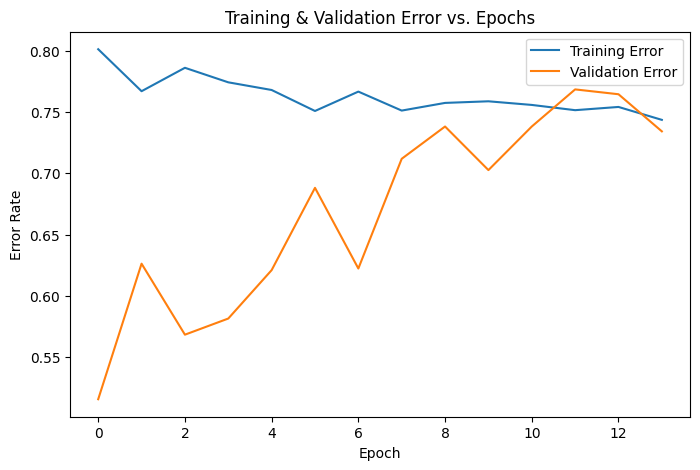

In [10]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Split your original training arrays X_train, y_train into train & validation (20% stratified)
X_train_base, X_val, y_train_base, y_val = train_test_split(
    X_train, y_train,
    test_size=0.20,
    stratify=y_train,
    random_state=42
)

# 2. Wrap your numpy-based augment_image() so it works in a tf.data pipeline
def augment_image_tf(img, lbl):
    aug = tf.numpy_function(func=augment_image, inp=[img], Tout=tf.uint8)
    aug.set_shape([224, 224, 3])             # must set shape manually after numpy_function
    return aug, lbl

# 3. Build tf.data pipelines
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train_base, y_train_base))
    .shuffle(buffer_size=len(X_train_base))
    .map(augment_image_tf, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(5)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(5)
    .prefetch(tf.data.AUTOTUNE)
)

# 4. Early stopping callback
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

# 5. Train for up to 100 epochs with early stopping
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks
)

# 6. Compute error rates and plot
train_error = [1.0 - acc for acc in history.history['accuracy']]
val_error   = [1.0 - acc for acc in history.history['val_accuracy']]

plt.figure(figsize=(8, 5))
plt.plot(train_error, label='Training Error')
plt.plot(val_error,   label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.title('Training & Validation Error vs. Epochs')
plt.legend()
plt.show()

v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models

In [24]:
from tensorflow.keras.utils import to_categorical
import numpy as np

def ensure_onehot(y, num_classes):
    y = np.asarray(y)
    # if y is already one-hot encoded, return it
    if y.ndim == 1 or (y.ndim == 2 and y.shape[1] != num_classes):
        return to_categorical(y, num_classes)
    return y

# 1. Ensure y_train_base, y_val, y_test are one-hot encoded
y_train_cat = ensure_onehot(y_train_base, NUM_CLASSES)
y_val_cat   = ensure_onehot(y_val,        NUM_CLASSES)
y_test_cat  = ensure_onehot(y_test,       NUM_CLASSES)

# 2. Evaluate each model on train, val, and test sets
records = []
for name, model in models.items():
    for split, X_split, y_split in [
        ('train', X_train_base, y_train_cat),
        ('val',   X_val,        y_val_cat),
        ('test',  X_test,       y_test_cat)
    ]:
        prec, rec, f1, auc = evaluate_model(model, X_split, y_split, batch_size=32)
        records.append({
            'model':     name,
            'split':     split,
            'precision': prec,
            'recall':    rec,
            'f1':        f1,
            'auc':       auc
        })

import pandas as pd
df = pd.DataFrame(records)
df_metrics = df.pivot_table(
    index='model',
    columns='split',
    values=['precision','recall','f1','auc']
)
df_metrics.columns = [f"{metric}_{split}" for metric, split in df_metrics.columns]
display(df_metrics)

best_by_f1  = df_metrics['f1_test'].idxmax()
best_by_auc = df_metrics['auc_test'].idxmax()
print(f"Best model by test F1 : {best_by_f1}")
print(f"Best model by test AUC: {best_by_auc}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 47s 497ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 500ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 937ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 908ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 909ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 694s 7s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step


,auc_test,auc_train,auc_val,f1_test,f1_train,f1_val,precision_test,precision_train,precision_val,recall_test,recall_train,recall_val
model,,,,,,,,,,,,
EfficientNetB0,0.642939,0.660304,0.673406,0.062994,0.062969,0.062697,0.037605,0.037589,0.037412,0.193920,0.193878,0.193421
ResNet101,0.734647,0.741095,0.752280,0.141768,0.154548,0.157142,0.115829,0.126703,0.128966,0.250524,0.261685,0.261842
ResNet50,0.720413,0.740231,0.759698,0.107151,0.123198,0.118433,0.117196,0.122014,0.127625,0.219078,0.243252,0.232895
VGG16,0.854023,0.900537,0.894171,0.317436,0.313897,0.329289,0.581837,0.707881,0.704234,0.394130,0.408163,0.413158


Best model by test F1 : VGG16
Best model by test AUC: VGG16


references:   
https://keras.io/getting_started/intro_to_keras_for_engineers/  
https://builtin.com/data-science/transfer-learning  
ChatGPT